(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)
i= 0 train acc, test acc | 0.09751666666666667, 0.0974
i= 600 train acc, test acc | 0.79925, 0.8012
i= 1200 train acc, test acc | 0.8787333333333334, 0.8819
i= 1800 train acc, test acc | 0.8995333333333333, 0.9008
i= 2400 train acc, test acc | 0.9099333333333334, 0.9115
i= 3000 train acc, test acc | 0.9151666666666667, 0.9174
i= 3600 train acc, test acc | 0.9203833333333333, 0.9219
i= 4200 train acc, test acc | 0.9244, 0.9266
i= 4800 train acc, test acc | 0.9288833333333333, 0.9302
i= 5400 train acc, test acc | 0.9306166666666666, 0.9321
i= 6000 train acc, test acc | 0.9340666666666667, 0.9348
i= 6600 train acc, test acc | 0.93695, 0.9365
i= 7200 train acc, test acc | 0.939, 0.9396
i= 7800 train acc, test acc | 0.9412666666666667, 0.9413
i= 8400 train acc, test acc | 0.9433, 0.9438
i= 9000 train acc, test acc | 0.9444833333333333, 0.9431
i= 9600 train acc, test acc | 0.9472166666666667, 0.946


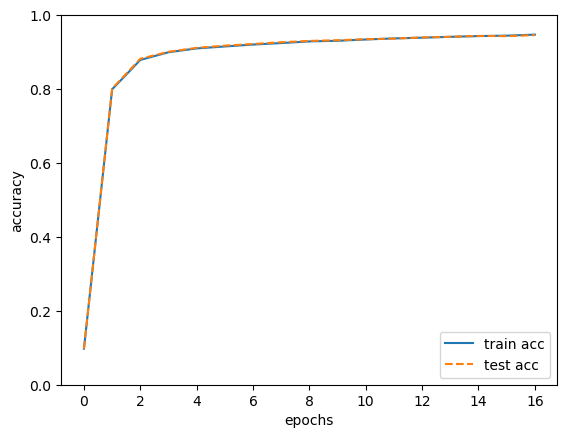

In [ ]:
#################################################################
# Error BackPropagation Two-Layer NN (Numerical Differentiation)
#################################################################
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict


class Affine:
    def __init__(self, W, b):
        self.x = None
        self.W = W
        self.b = b
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        return dx

def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out

        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx

def relu(x):
    return np.maximum(0, x)

def relu_grad(x):
    grad = np.zeros(x)
    grad[x>=0] = 1
    return grad

class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None # softmax의 출력
        self.t = None # 정답 레이블(원-핫 인코딩 형태)
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)

        return self.loss
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 떼
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arrrage(batch_size).self.t] -= 1
            dx = dx/batch_size

        return dx

def cross_entropy_error(y, t):
    if y.ndim ==1:
        t=t.reshape(1, t.size)
        y=y.reshape(1, y.size)

    batch_size = y.shape[0]
    delta = 1e-7
    return -np.sum(t*np.log(y+delta)) / batch_size

def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)

    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)

        x[idx] = tmp_val - h
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)

        x[idx] = tmp_val # 값 복원
        it.iternext()

    return grad

class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        #계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        #self.layers['Relu1'] = Relu()
        self.layers['Sigmoid1'] = Sigmoid()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x  = layer.forward(x)

        return(x)

    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)

        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1:
            t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])

        return accuracy

    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        #결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

# 데이터 읽기
from mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normalize=True, one_hot_label=True)

print(x_train.shape)
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)


network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터
iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    #print('x_batch =', x_batch.shape)
    #print('W1 =', network.params['W1'].shape)

    #noise = np.random.rand(100).astype(np.float32)
    #np.zeros_like(noise)


    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch) # 수치 미분 방식
    grad = network.gradient(x_batch, t_batch) #오차역전파법 방식 (훨씬 빠름)

    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("i=", i, "train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()